# Impact of neglecting the self-demagnetization

### Import the required modules

In [1]:
%matplotlib inline
import numpy as np
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap
from fatiando import utils, gridder
import mesher, triaxial_ellipsoid
from plot_functions import savefig

In [2]:
# Set some plot parameters
from matplotlib import rcParams
rcParams['figure.dpi'] = 300.
rcParams['font.size'] = 6
rcParams['xtick.labelsize'] = 'medium'
rcParams['ytick.labelsize'] = 'medium'
rcParams['axes.labelsize'] = 'large'
rcParams['legend.fontsize'] = 'medium'
rcParams['savefig.dpi'] = 300.

### Warrego magnetite body

In [3]:
# semi-axes (in m)
a = 490.7
b = 69.7
c = 30.

# orientation angles (in degrees)
strike = -34.
dip = 66.1
rake = 45.

In [4]:
# isotropic susceptibility (in SI)
chi_true = 1.690

In [5]:
warrego = mesher.TriaxialEllipsoid(0, 0, 500, a, b, c, strike, dip, rake,
                                   props={'principal susceptibilities': [chi_true, chi_true, chi_true],
                                          'susceptibility angles': [strike, dip, rake]})

In [6]:
# demagnetizing factors
n11, n22, n33 = triaxial_ellipsoid.demag_factors(warrego)

### Local-geomagnetic field (nT)

##### Main coordinate system

In [7]:
F_xyz = np.array([32610., 0., 39450.])
F, inc, dec = utils.vec2ang(F_xyz)

In [8]:
print F, inc, dec

51183.1476172 50.4223208627 0.0


##### Local coordinate system

In [9]:
F_local = np.dot(warrego.transf_matrix.T, F_xyz)

In [10]:
print F_local

[-39396.00407387 -29894.12604429 -13191.31119563]


### Observation points (m)

In [11]:
area = [-2000., 2000., -2000., 2000.]
shape = (100, 100)
xp, yp, zp = gridder.regular(area, shape, z = 0.)

### Total-field anomaly (nT)

### $\chi = \chi_{true}$

In [12]:
# true magnetization in the main system
mag_true = triaxial_ellipsoid.magnetization(warrego, F, inc, dec, demag=True)

# approximated magnetization
mag_true_approx = triaxial_ellipsoid.magnetization(warrego, F, inc, dec, demag=False)

# relative error
mag_true_norm = np.linalg.norm(mag_true, ord = 2)
mag_true_approx_norm = np.linalg.norm(mag_true_approx, ord = 2)
delta_mag_true_norm = np.linalg.norm(mag_true - mag_true_approx, ord = 2)
epsilon_true = delta_mag_true_norm/mag_true_norm

print 'epsilon = %.3f percent' % (epsilon_true*100)

epsilon = 28.060 percent


In [13]:
print mag_true, mag_true_norm

[ 32.87303675 -10.83241722  47.33126755] 58.6363939522


In [14]:
print mag_true_approx, mag_true_approx_norm

[  4.38558608e+01  -9.98246881e-16   5.30546982e+01] 68.834130496


In [15]:
tf_true = triaxial_ellipsoid.tf(xp, yp, zp, [warrego], F, inc, dec)

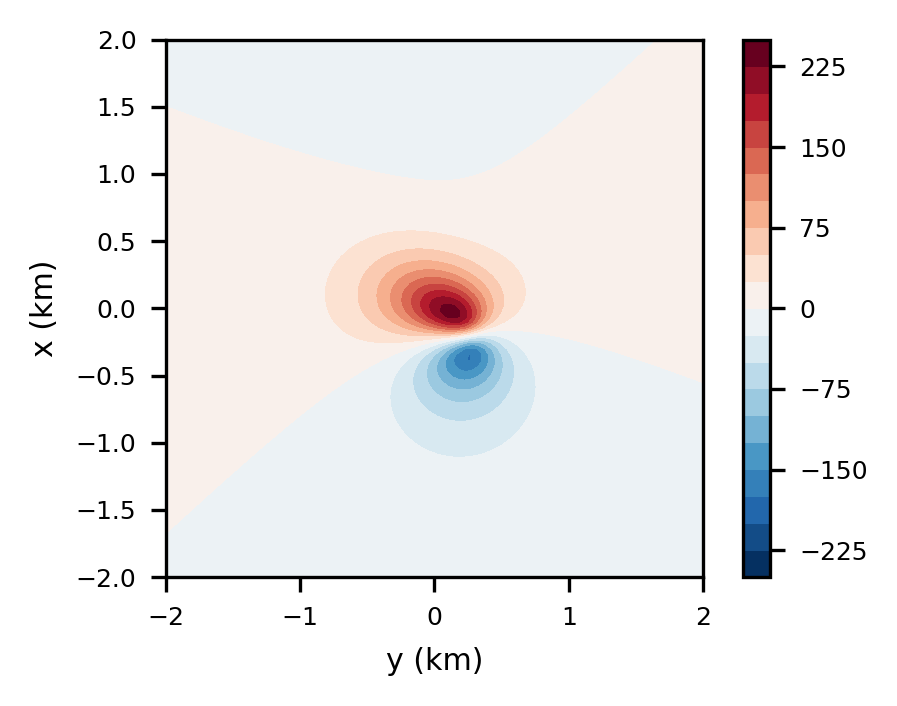

In [16]:
plt.figure(figsize=(3.15, 7./3))
plt.axis('scaled')

ranges = np.max(np.abs([np.min(tf_true), np.max(tf_true)]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             tf_true.reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.ylabel('x (km)')
plt.xlabel('y (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
cbar = plt.colorbar()

plt.tight_layout()
savefig('total-field_anomaly.pdf')

plt.show()

In [17]:
print 'max = %.3f' % (tf_true.max())
print 'min = %.3f' % (tf_true.min())
print 'peak-to-peak amplitude = %.3f' % (tf_true.max() - tf_true.min())

max = 236.640
min = -176.232
peak-to-peak amplitude = 412.872


In [18]:
tf_true_approx = triaxial_ellipsoid.tf(xp, yp, zp, [warrego], F, inc, dec,
                                       demag = False)

In [19]:
residuals_true = tf_true_approx - tf_true

In [20]:
print 'residuals min  = %.3f' % (residuals_true.min())
print 'residuals mean = %.3f' % (residuals_true.mean())
print 'residuals max  = %.3f' % (residuals_true.max())

residuals min  = -110.064
residuals mean = -0.379
residuals max  = 30.693


In [21]:
misfit_true = np.sum(residuals_true*residuals_true)/residuals_true.size

In [22]:
print 'misfit = %.3f' % misfit_true

misfit = 95.336


In [23]:
print 'peak-to-peak field amplitude = %.3f absolute' % \
(residuals_true.max() - residuals_true.min())

peak-to-peak field amplitude = 140.757 absolute


In [24]:
print 'peak-to-peak field amplitude = %.3f percent' % \
(100*(residuals_true.max() - residuals_true.min())/(tf_true.max() - tf_true.min()))

peak-to-peak field amplitude = 34.092 percent


### $\chi = 0.1$

In [25]:
# isotropic susceptibility commonly used as an upper limit
# to neglect the self-demagnetization
chi_usual = 0.1

In [26]:
warrego_usual = mesher.TriaxialEllipsoid(0, 0, 500, a, b, c, strike, dip, rake,
                                         props={'principal susceptibilities': [chi_usual, chi_usual, chi_usual],
                                         'susceptibility angles': [strike, dip, rake]})

In [27]:
# true magnetization in the main system
mag_usual = triaxial_ellipsoid.magnetization(warrego_usual, F, inc, dec,
                                            demag=True)

# approximated magnetization
mag_usual_approx = triaxial_ellipsoid.magnetization(warrego_usual, F, inc, dec,
                                                   demag=False)

# relative error
mag_usual_norm = np.linalg.norm(mag_usual, ord = 2)
mag_usual_approx_norm = np.linalg.norm(mag_usual_approx, ord = 2)
delta_mag_usual_norm = np.linalg.norm(mag_usual - mag_usual_approx, ord = 2)
epsilon_usual = delta_mag_usual_norm/mag_usual_norm

print 'epsilon = %.3f percent' % (epsilon_usual*100)

epsilon = 2.390 percent


In [28]:
print mag_usual, mag_usual_norm

[ 2.52299184 -0.06013363  3.11944828] 4.01248818584


In [29]:
print mag_usual_approx, mag_usual_approx_norm

[  2.59502135e+00  -2.42242639e-16   3.13933125e+00] 4.07302547314


In [30]:
tf_usual = triaxial_ellipsoid.tf(xp, yp, zp, [warrego_usual], F, inc, dec)

In [31]:
tf_usual_approx = triaxial_ellipsoid.tf(xp, yp, zp, [warrego_usual], F, inc, dec,
                                        demag = False)

In [32]:
residuals_usual = tf_usual_approx - tf_usual

In [33]:
print 'residuals min  = %.3f' % (residuals_usual.min())
print 'residuals mean = %.3f' % (residuals_usual.mean())
print 'residuals max  = %.3f' % (residuals_usual.max())

residuals min  = -0.690
residuals mean = -0.003
residuals max  = 0.145


In [34]:
misfit_usual = np.sum(residuals_usual*residuals_usual)/residuals_usual.size

In [35]:
print 'misfit = %.3f' % misfit_usual

misfit = 0.003


In [36]:
print 'peak-to-peak field amplitude = %.3f absolute' % \
(residuals_usual.max() - residuals_usual.min())

peak-to-peak field amplitude = 0.836 absolute


In [37]:
print 'peak-to-peak field amplitude = %.3f percent' % \
(100*(residuals_usual.max() - residuals_usual.min())/(tf_usual.max() - tf_usual.min()))

peak-to-peak field amplitude = 2.876 percent


### $\chi = \chi_{max}$

In [38]:
# proposed upper maximum isotropic susceptibility
# to guarantee a relative error lower than or equal to epsilon
#epsilon_max = 0.07 # this epsilon generates a misfit similar 
                   # to that obtained by using the usual chi = 0.1
epsilon_max = 0.08
chi_max = epsilon_max/n33

print 'chi_max = %.3f SI' % chi_max

chi_max = 0.116 SI


In [39]:
warrego_max = mesher.TriaxialEllipsoid(0, 0, 500, a, b, c, strike, dip, rake,
                                       props={'principal susceptibilities': [chi_max, chi_max, chi_max],
                                              'susceptibility angles': [strike, dip, rake]})

In [40]:
# true magnetization in the main system
mag_max = triaxial_ellipsoid.magnetization(warrego_max, F, inc, dec,
                                           demag=True)

# approximated magnetization
mag_max_approx = triaxial_ellipsoid.magnetization(warrego_max, F, inc, dec,
                                                  demag=False)

# relative error
mag_max_norm = np.linalg.norm(mag_max, ord = 2)
mag_max_approx_norm = np.linalg.norm(mag_max_approx, ord = 2)
delta_mag_max_norm = np.linalg.norm(mag_max - mag_max_approx, ord = 2)

epsilon_calculated = delta_mag_max_norm/mag_max_norm

print 'epsilon = %.3f percent' % (epsilon_calculated*100)

epsilon = 2.759 percent


In [41]:
print mag_max, mag_max_norm

[ 2.91474117 -0.08046227  3.61545965] 4.64475389679


In [42]:
print mag_max_approx, mag_max_approx_norm

[  3.01081106e+00  -2.77759736e-16   3.64233353e+00] 4.72562978042


In [43]:
tf_max = triaxial_ellipsoid.tf(xp, yp, zp, [warrego_max], F, inc, dec)

In [44]:
tf_max_approx = triaxial_ellipsoid.tf(xp, yp, zp, [warrego_max], F, inc, dec,
                                      demag = False)

In [45]:
residuals_max = tf_max_approx - tf_max

In [46]:
print 'residuals min  = %.3f' % (residuals_max.min())
print 'residuals mean = %.3f' % (residuals_max.mean())
print 'residuals max  = %.3f' % (residuals_max.max())

residuals min  = -0.921
residuals mean = -0.004
residuals max  = 0.195


In [47]:
misfit_max = np.sum(residuals_max*residuals_max)/residuals_max.size

In [48]:
print 'misfit = %.3f' % misfit_max

misfit = 0.006


In [49]:
print 'peak-to-peak field amplitude = %.3f absolute' % \
(residuals_max.max() - residuals_max.min())

peak-to-peak field amplitude = 1.116 absolute


In [50]:
print 'peak-to-peak field amplitude = %.3f percent' % \
(100*(residuals_max.max() - residuals_max.min())/(tf_max.max() - tf_max.min()))

peak-to-peak field amplitude = 3.322 percent


### Comparison

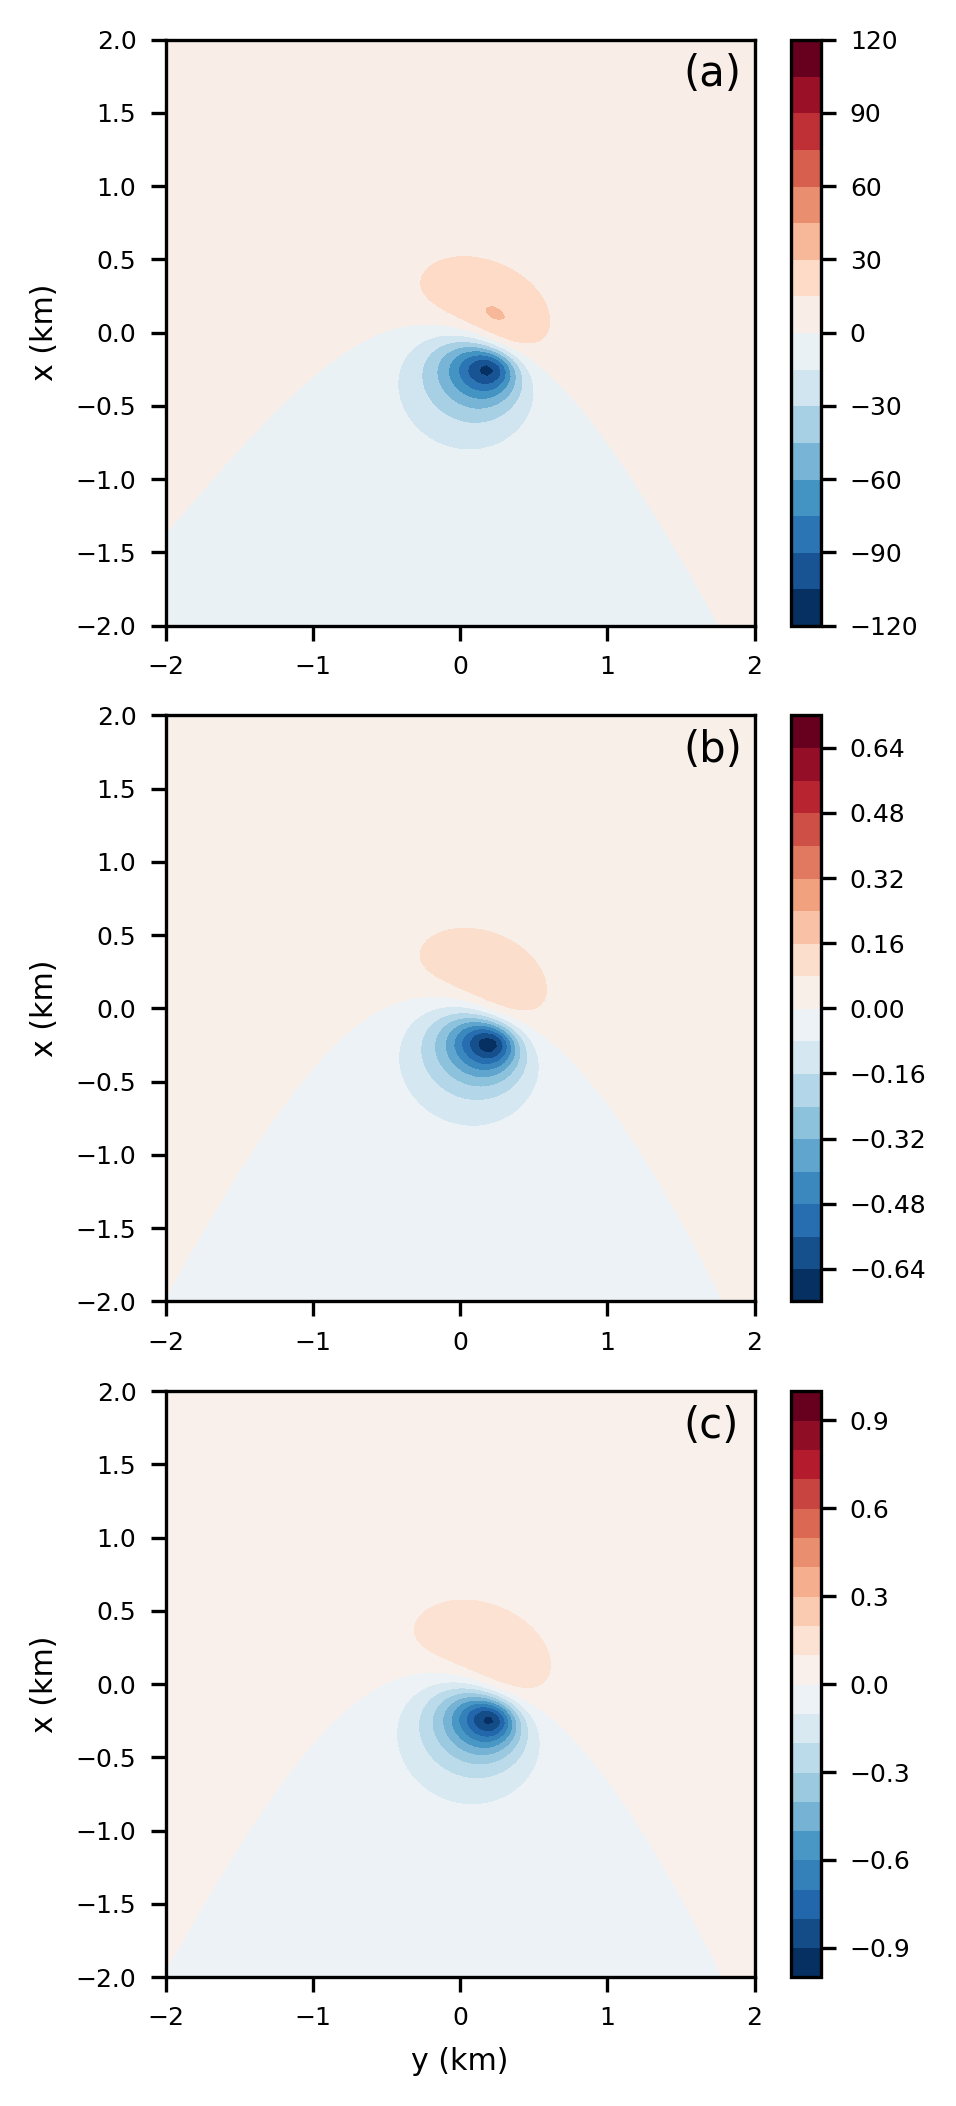

In [51]:
plt.figure(figsize=(3.15, 7))
plt.axis('scaled')

ranges = np.max(np.abs([np.min(residuals_true), np.max(residuals_true)]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.subplot(3,1,1)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             residuals_true.reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.ylabel('x (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
cbar = plt.colorbar()
plt.annotate(s='(a)', xy=(0.88,0.92),
             xycoords = 'axes fraction', color='k',
             fontsize = 10)

ranges = np.max(np.abs([np.min(residuals_usual), np.max(residuals_usual)]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.subplot(3,1,2)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             residuals_usual.reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.ylabel('x (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
plt.colorbar()
plt.annotate(s='(b)', xy=(0.88,0.92),
             xycoords = 'axes fraction', color='k',
             fontsize = 10)

ranges = np.max(np.abs([np.min(residuals_max), np.max(residuals_max)]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.subplot(3,1,3)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             residuals_max.reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.ylabel('x (km)')
plt.xlabel('y (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
plt.colorbar()
plt.annotate(s='(c)', xy=(0.88,0.92), 
             xycoords = 'axes fraction', color='k',
             fontsize = 10)

plt.tight_layout()
savefig('field_differences.pdf')

plt.show()